<a href="https://colab.research.google.com/github/pranscript/neural_jupyter/blob/master/Fashion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline                                               
%config InlineBackend.figure_format = 'retina'                   

import numpy as np
import torch

In [0]:
import matplotlib.pyplot as plt                                                  
from torchvision import datasets, transforms                       
from torch import nn                                                 
import torch.nn.functional as F                                   
from torch import optim 

In [0]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
# 'download=true' downloads the dataset, 'train=true' creates dataset from training otherwise from test.
# dataloader provides an batch loading function for dataset. 'batch_size' set no. of samples per batch to load. 'Shuffle=true' shuffles data every epoch.
trainset = datasets.FashionMNIST('~/.pytorch/Fashion_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

In [0]:
input_size = 784                                                    
hidden_sizes1 = [256, 128]
hidden_sizes2 = [128, 64]
output_size = 10

In [6]:
from collections import OrderedDict
model = nn.Sequential(OrderedDict([
                      ('fc1', nn.Linear(input_size, hidden_sizes1[0])),
                      ('relu1', nn.ReLU()),
                      ('fc2', nn.Linear(hidden_sizes1[0], hidden_sizes1[1])),
                      ('relu2', nn.ReLU()),
                      ('fc3', nn.Linear(hidden_sizes2[0], hidden_sizes2[1])),
                      ('relu3', nn.ReLU()),
                      ('output', nn.Linear(hidden_sizes2[1], output_size)),
                      ('logsoftmax', nn.LogSoftmax(dim=1))]))

criterion = nn.NLLLoss()      # negative log loss
optimizer = optim.Adam(model.parameters(), lr=0.003)
print(model)

Sequential(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (relu3): ReLU()
  (output): Linear(in_features=64, out_features=10, bias=True)
  (logsoftmax): LogSoftmax()
)


In [7]:
#images, labels = next(iter(trainloader))

epochs = 10
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # TODO: Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")

Training loss: 0.5204627874341092
Training loss: 0.39203090887905945
Training loss: 0.35481434757870906
Training loss: 0.3328772822597515
Training loss: 0.3148289869414337
Training loss: 0.3030909502398231
Training loss: 0.2867367056641243
Training loss: 0.2809798066009845
Training loss: 0.2745936360996542
Training loss: 0.2672061528970819


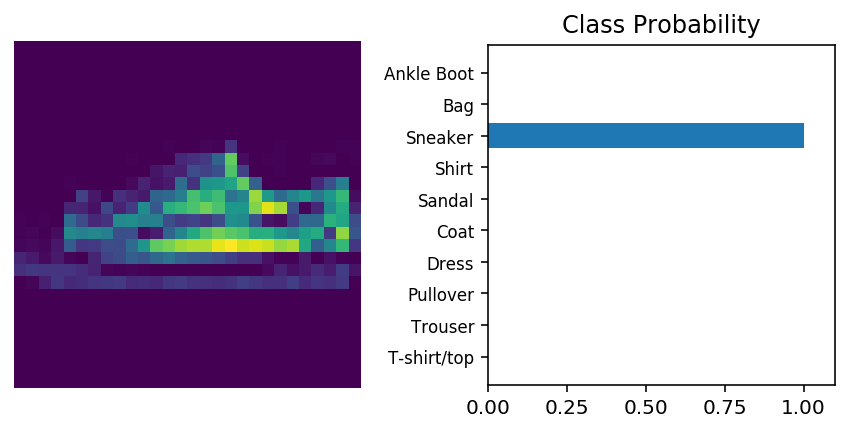

In [13]:
images, labels = next(iter(trainloader))
img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
#print(logps)                
ps = torch.exp(logps)
#print(ps)

img = img.view(1, 28, 28)
ps = ps.data.numpy().squeeze()
fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
ax1.axis('off')
ax2.barh(np.arange(10), ps)
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)
plt.tight_layout()